<a href="https://colab.research.google.com/github/primods/LR_HEMO/blob/main/LR_KidneyData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import the packages for Exploratory Data Analysis and Model Creation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

from sklearn.linear_model import Lasso, LinearRegression, ElasticNetCV, RidgeCV, LassoCV

from scipy.stats import lognorm

import pickle

sns.set(rc={'figure.figsize':(8,5)})
sns.set_theme("paper")

In [2]:
#Installing random generator of data that we use for random colors and change the setting for python
#warnings for clean outputs
!pip install faker
from faker import Factory
import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#Create the Dataframe from CSV file and check the columns
df = pd.read_csv("kidney_disease.csv").dropna(thresh=20)
df.columns

Index(['id', 'age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr',
       'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'classification'],
      dtype='object')

In [4]:
#Select the relevant blood laboratory values (excluding other like bp-blood pressure-)
#and separate categorical from numerical values for later use

df = df[["wc","pcv","rc","ane","classification","hemo"]]
df = df.dropna(subset=["hemo","ane","classification"])
col_names = list(df.columns)
num_columns = list(df[["wc","pcv","rc"]].columns)
cat_columns = list(df[["ane","classification"]].columns)

In [5]:
#Crete X and y dataframe and splitting in train and test sets
X = df[num_columns+cat_columns]
y = df["hemo"]
df_train, df_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=28)

In [6]:
#checking for NA values
df_train.isna().sum()

wc                23
pcv                5
rc                44
ane                0
classification     0
dtype: int64

In [7]:
#Cheking for inconsistencies in the train data
for i in df_train.columns:
  print(i)
  print(df_train[i].unique())
  print("_______________")

wc
['5300' '7000' '9100' '12800' nan '10400' '4200' '8400' '5700' '9300'
 '6700' '5800' '8000' '6200' '6900' '8100' '10500' '10300' '6300' '9800'
 '8200' '11900' '9500' '9200' '11000' '10700' '16700' '7300' '6000' '9000'
 '12100' '7900' '8600' '12000' '6600' '6500' '4300' '9400' '3800' '10200'
 '11400' '7500' '8300' '12700' '4700' '4900' '5500' '2200' '12400' '4500'
 '7200' '7800' '2600' '9600' '8800' '6400' '7400' '15700' '18900' '26400'
 '5900' '14900' '14600' '4100' '5000' '\t?' '5600' '7700' '6800' '12200'
 '16300' '5200' '15200' '5400' '7100' '8500' '10900' '11200' '12300']
_______________
pcv
['41' '52' '30' '46' '34' '33' '48' '43' '24' '29' '38' '26' '50' '28'
 '40' '42' '32' '27' '44' '39' '35' '14' '36' '47' '16' '37' '17' '22' nan
 '31' '49' '53' '\t43' '45' '54' '15' '20' '25' '51' '19' '23' '9']
_______________
rc
['5.9' nan '3.2' '5.8' '4.9' '4.5' '3.3' '3.7' '5.4' '6.1' '5.1' '6.2'
 '3.4' '4' '5.0' '4.8' '3.9' '2.6' '5.3' '4.6' '\t?' '3.1' '5.5' '6.4'
 '2.5' '2.1' '3.8' 

In [8]:
#Manually imputing values
df_train["classification"].replace("ckd\t","ckd", inplace=True)
df_train["wc"].replace(["\t?"],np.nan, inplace=True)
df_train["pcv"].replace(["\t43"],43, inplace=True)
df_train["rc"].replace(["\t?"],np.nan, inplace=True)

#Sanity check
for i in df_train.columns:
  print(i)
  print(df_train[i].unique())
  print("_______________")

wc
['5300' '7000' '9100' '12800' nan '10400' '4200' '8400' '5700' '9300'
 '6700' '5800' '8000' '6200' '6900' '8100' '10500' '10300' '6300' '9800'
 '8200' '11900' '9500' '9200' '11000' '10700' '16700' '7300' '6000' '9000'
 '12100' '7900' '8600' '12000' '6600' '6500' '4300' '9400' '3800' '10200'
 '11400' '7500' '8300' '12700' '4700' '4900' '5500' '2200' '12400' '4500'
 '7200' '7800' '2600' '9600' '8800' '6400' '7400' '15700' '18900' '26400'
 '5900' '14900' '14600' '4100' '5000' '5600' '7700' '6800' '12200' '16300'
 '5200' '15200' '5400' '7100' '8500' '10900' '11200' '12300']
_______________
pcv
['41' '52' '30' '46' '34' '33' '48' '43' '24' '29' '38' '26' '50' '28'
 '40' '42' '32' '27' '44' '39' '35' '14' '36' '47' '16' '37' '17' '22' nan
 '31' '49' '53' 43 '45' '54' '15' '20' '25' '51' '19' '23' '9']
_______________
rc
['5.9' nan '3.2' '5.8' '4.9' '4.5' '3.3' '3.7' '5.4' '6.1' '5.1' '6.2'
 '3.4' '4' '5.0' '4.8' '3.9' '2.6' '5.3' '4.6' '3.1' '5.5' '6.4' '2.5'
 '2.1' '3.8' '4.3' '5.2' '4.2

In [9]:
#One-hot encoding the categorical values
encoder = OneHotEncoder(sparse=False)

df_train_ohe = encoder.fit_transform(df_train[["ane","classification"]])

#Check the generated columns by the encoder
list(encoder.get_feature_names_out())

['ane_no', 'ane_yes', 'classification_ckd', 'classification_notckd']

In [10]:
#Check the data types in the dataframe
df_train_num = df_train[["wc","pcv","rc"]]
df_train_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193 entries, 285 to 333
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   wc      169 non-null    object
 1   pcv     188 non-null    object
 2   rc      148 non-null    object
dtypes: object(3)
memory usage: 6.0+ KB


In [11]:
#Change the data type to generate a basic summary statistics
df_train_num["wc"] = df_train_num["wc"].astype(float, errors = 'raise')
df_train_num["rc"] = df_train_num["rc"].astype(float, errors = 'raise')
df_train_num["pcv"] = df_train_num["pcv"].astype(float, errors = 'raise')

df_train_num.describe()

,wc,pcv,rc
count,169.000000,188.000000,148.000000
mean,8392.307692,38.489362,4.716216
std,3101.382180,9.078086,1.021407
min,2200.000000,9.000000,2.100000
25%,6400.000000,33.000000,3.900000
50%,8000.000000,40.000000,4.800000
75%,9800.000000,45.000000,5.500000
max,26400.000000,54.000000,6.500000


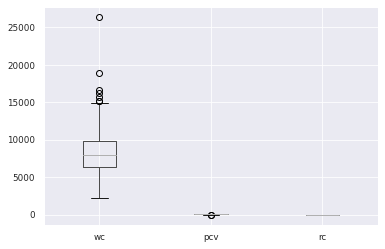

In [12]:
#Boxplotting the numerical data visualization of the statistics
df_train_num.boxplot()

<Figure size 432x288 with 0 Axes>

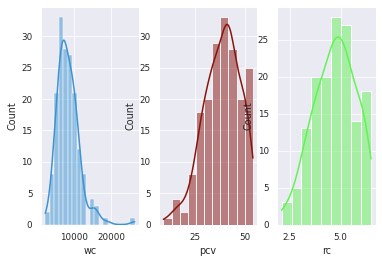

In [13]:
#Check distributions
fake = Factory.create()
plt.figure()
ncols = len(df_train_num.columns)
fig, axs = plt.subplots(1, ncols)
sns.set(rc={'figure.figsize':(12,4)})


for i,j in zip(df_train_num.columns,range(ncols)):
  sns.histplot(df_train_num[i], kde=True, ax=axs[j],color=fake.hex_color())

In [14]:
#Creating imputer for the NA values
im = SimpleImputer(missing_values=np.nan,strategy="mean")
#Saving column name for data visualization
columns_names = df_train_num.columns
#Imputed data
df_train_num = im.fit_transform(df_train_num)
#Scale the data
norm = StandardScaler()
df_train_num = pd.DataFrame(norm.fit_transform(df_train_num))
df_train_num.columns = columns_names

In [15]:
#Basic statistics of the new data
df_train_num.describe()

,wc,pcv,rc
count,1.930000e+02,1.930000e+02,1.930000e+02
mean,2.531078e-16,-2.300980e-17,4.049725e-16
std,1.002601e+00,1.002601e+00,1.002601e+00
min,-2.140037e+00,-3.300114e+00,-2.934909e+00
25%,-5.848548e-01,-6.143069e-01,-4.669174e-01
50%,0.000000e+00,1.690534e-01,0.000000e+00
75%,4.173736e-01,7.285966e-01,5.427157e-01
max,6.223387e+00,1.735774e+00,2.001075e+00


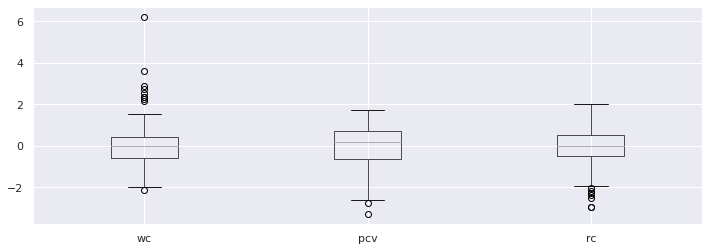

In [16]:
#Boxplotting of the new data
df_train_num.boxplot()

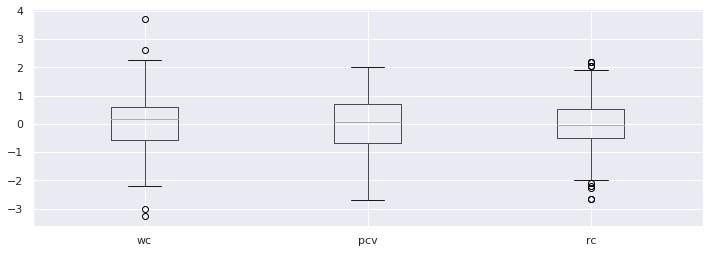

In [17]:
#Transforming the data with Yeo-Johnson to make it more normal and
#plot to visualize
transformer = PowerTransformer(method="yeo-johnson")
df_train_num = pd.DataFrame(transformer.fit_transform(df_train_num))
df_train_num.columns = columns_names
pd.DataFrame(df_train_num).boxplot()

<Figure size 864x288 with 0 Axes>

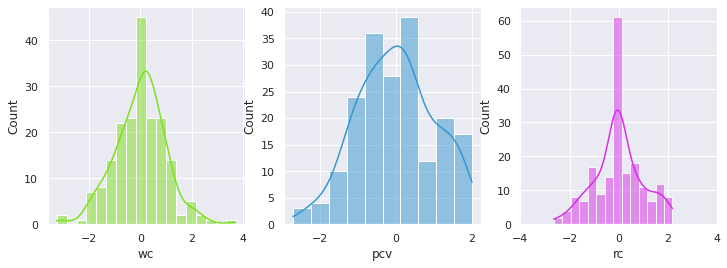

In [18]:
#Plot the new distributions
plt.figure()
ncols = len(df_train_num.columns)
fig, axs = plt.subplots(1, ncols)
sns.set(rc={'figure.figsize':(12,4)})
plt.xlim(-4,4)

for i,j in zip(df_train_num.columns,range(ncols)):
  sns.histplot(df_train_num[i], kde=True, ax=axs[j],color=fake.hex_color())

In [19]:
#All previous steps can now be sumarized in a few lines of code
#using a pipeline!
numeric_transformer = Pipeline([
                 ("imputer",SimpleImputer(missing_values=np.nan,strategy="mean")),
                 ("scaler",StandardScaler()),
                 ("transform",PowerTransformer(method="yeo-johnson"))
])

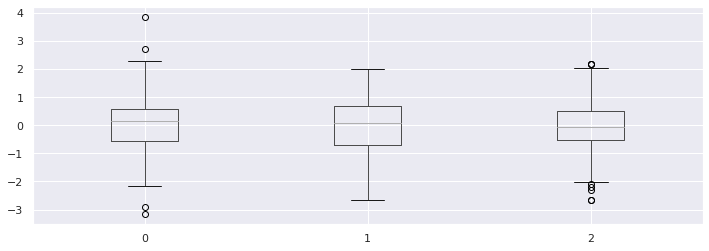

In [20]:
#Using the pipeline
pd.DataFrame(numeric_transformer.fit_transform(df_train_num)).boxplot()

In [21]:
#Using ColumnTransformer even Categorical values can be ingested in a pipeline
categorical_transformer = OneHotEncoder(sparse=False)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_columns),
        ("cat", categorical_transformer, cat_columns),
    ]
)

In [22]:
#Looking the preprocessed Dataframe from pipeline
df_train = pd.DataFrame(preprocessor.fit_transform(df_train))
#Naming the columns
all_col_names = [num_columns + list(preprocessor.transformers_[1][1].get_feature_names_out())]
df_train.columns = all_col_names
df_train.head(3)

,wc,pcv,rc,ane_no,ane_yes,classification_ckd,classification_notckd
0,-1.298389,0.192584,1.388252,1.0,0.0,0.0,1.0
1,-0.415470,1.699867,-0.054922,1.0,0.0,1.0,0.0
2,-0.415470,-0.972618,-1.618009,1.0,0.0,1.0,0.0


In [23]:
#Training the first model (Ridge) ussing crossvalidation and printing the coefficient of determination 
#R2 score and CV = 15
ridge = RidgeCV(alphas=(0.1,0.2,0.5,1,2,5,10),cv=15)
ridge.fit(df_train,y_train)
ridge.score(df_train, y_train)

0.8066378868944614

In [24]:
#Second model using Lasso
lasso = LassoCV(eps=.01,n_alphas=100,cv=15, max_iter=100)
lasso.fit(df_train, y_train)
lasso.score(df_train,y_train)

0.8067816204357368

In [25]:
#Third model using ElasticNet
elastic = ElasticNetCV(l1_ratio=[0.01,0.2,0.5,0.7,0.9,1], eps=0.01/10,n_alphas=1000, cv=15)
elastic.fit(df_train, y_train)
elastic.score(df_train, y_train)

0.8075990448441086

In [26]:
#Print all the coefficient values by model
print(np.round(ridge.coef_,1))
print(np.round(lasso.coef_,1))
print(np.round(elastic.coef_,1))

[-0.1  1.4  0.5  0.5 -0.5 -0.6  0.6]
[-0.   1.6  0.4  1.  -0.  -1.2  0. ]
[-0.1  1.5  0.5  0.6 -0.6 -0.7  0.7]


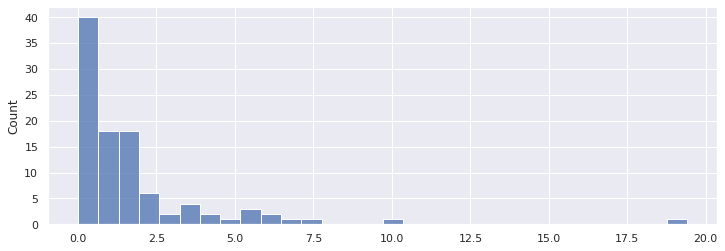

In [27]:
#Check the MSE score with Cross validation to make a basic summary statistics with CV=100
np.random.seed(22)

#Make the Mean Squared Error Scorer for the cross_val_score function
mse_scorer = make_scorer(mean_squared_error)
mse_ridge = cross_val_score(ridge, df_train, y_train, cv=100, scoring=mse_scorer)

#plot the distribution of the scores
sns.histplot(mse_ridge)

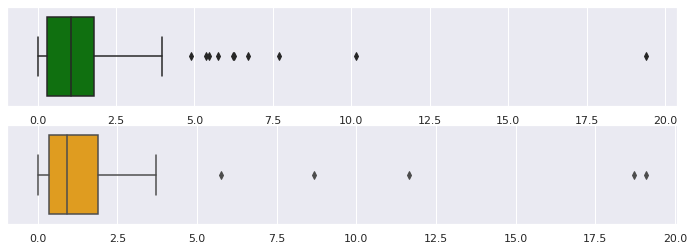

In [28]:
#Fitting to lognormal distribution since np.mean and typical measures
#can fail infering normality of the data
s, l, sd = lognorm.fit(mse_ridge)
#generate random values with parametres from the fitted data
dummy_lognorm = lognorm.rvs(s,l,sd,size=100)

#Asses the fitting
fig, axs = plt.subplots(2,1)
sns.boxplot(mse_ridge, ax=axs[0], color="green")
sns.boxplot(dummy_lognorm, ax = axs[1], color="orange")

Text(0.5, 0, 'MSE')

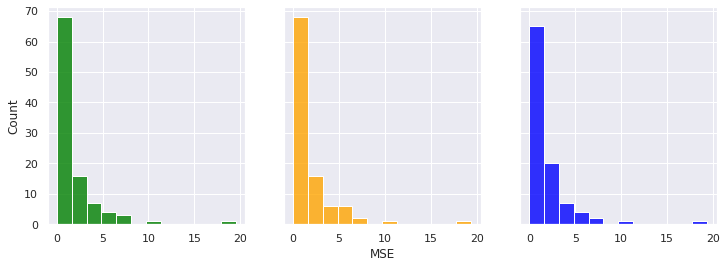

In [29]:
#Calculating for the last models
mse_lasso = cross_val_score(lasso, df_train, y_train, cv=100, scoring=mse_scorer)
mse_elastic = cross_val_score(elastic, df_train, y_train, cv=100, scoring=mse_scorer)

#Plot the distributions
fig,axs = plt.subplots(1,3,sharex=True,sharey=True)
sns.histplot(mse_lasso, bins=12, color="green", alpha=0.8, ax = axs[0])
sns.histplot(mse_ridge, bins=12, color="orange", alpha=0.8, ax=axs[1])
sns.histplot(mse_elastic, bins=12, color="blue", alpha=0.8, ax=axs[2])
axs[0].set_ylabel("Count")
axs[1].set_xlabel("MSE")

In [30]:
#Basic summary statistics from fitted score data
scores_models = [mse_lasso, mse_ridge, mse_elastic]
moments_models = []
for i in scores_models:
  s, l, sd = lognorm.fit(i)
  moments_models.append(list(np.round(lognorm.stats(s,l,sd,moments="mvsk"),2)))

pd.DataFrame(moments_models, columns=["Mean","Variance","Skewnes",
                                      "Kurtosis"], index=["Lasso","Ridge","Elastic"])

,Mean,Variance,Skewnes,Kurtosis
Lasso,1.93,14.59,13.28,819.55
Ridge,1.87,11.89,11.26,527.60
Elastic,1.88,12.10,11.38,542.07


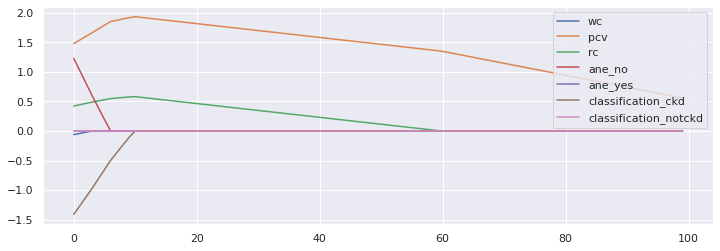

In [31]:
#Choosing lasso for the final model, since ElasticNet is computational expensive, and has less
#Parameters than Ridge regression
best_alpha = np.round(lasso.alpha_,3)
best_coeff = list(lasso.coef_)
#Plot the different coefficient values from different alphas(penalty parameter) to show
#feature selection made by Lasso regressiong
alphas = np.linspace(0,2,100)
coeff_weigths = []

for i in alphas:
  lasso = Lasso(alpha=i)
  lasso.fit(df_train, y_train)
  coeff_weigths.append(list(lasso.coef_))

plt.plot(pd.DataFrame(coeff_weigths))
plt.legend(list(all_col_names[0]))

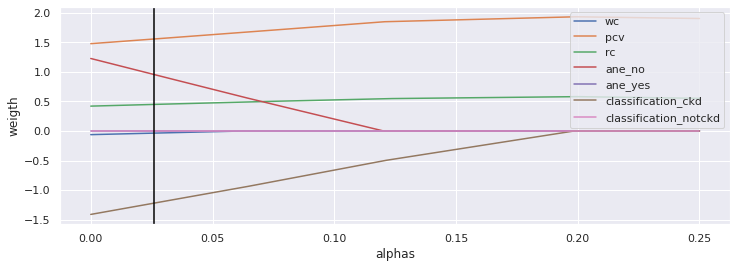

In [32]:
#Plotting the interval of the best alpha (~0.026)
#found through LassoCV 

alphas = np.linspace(0,0.25,500)
coeff_weigths = []

for i in alphas:
  lasso = Lasso(alpha=i)
  lasso.fit(df_train, y_train)
  coeff_weigths.append(list(lasso.coef_))

for i in range(7):
  sns.lineplot(alphas,pd.DataFrame(coeff_weigths)[i])

plt.legend(list(all_col_names[0]))
plt.xlabel("alphas")
plt.ylabel("weigth")
plt.axvline(x = best_alpha, color = 'black')

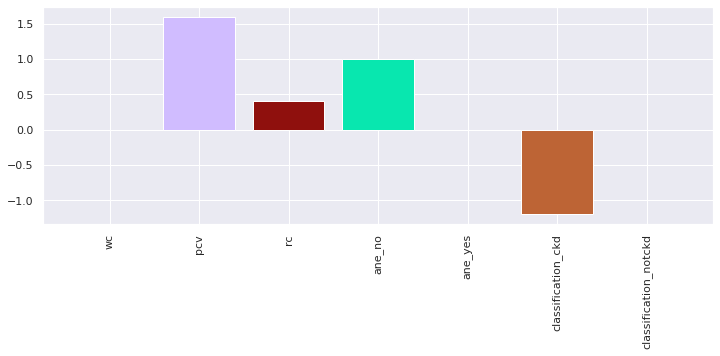

In [33]:
#barplot the Coefficient weights for the Lasso model
#Generate random colors for chart bar
random_colors = []
for i in range(len(best_coeff)):
  random_colors.append(fake.hex_color())

#Bar plot the coefficient weights
plt.bar(np.arange(len(best_coeff)),np.round(best_coeff,1), color=random_colors)
plt.xticks(np.arange(len(best_coeff)), all_col_names[0], rotation=90);

In [34]:
#Making polynomial features 
df_train.columns = df_train.columns.get_level_values(0)

poly = PolynomialFeatures(2, interaction_only=True)

df_train_poly = pd.DataFrame(poly.fit_transform(df_train))

poly.get_feature_names_out()

array(['1', 'wc', 'pcv', 'rc', 'ane_no', 'ane_yes', 'classification_ckd',
       'classification_notckd', 'wc pcv', 'wc rc', 'wc ane_no',
       'wc ane_yes', 'wc classification_ckd', 'wc classification_notckd',
       'pcv rc', 'pcv ane_no', 'pcv ane_yes', 'pcv classification_ckd',
       'pcv classification_notckd', 'rc ane_no', 'rc ane_yes',
       'rc classification_ckd', 'rc classification_notckd',
       'ane_no ane_yes', 'ane_no classification_ckd',
       'ane_no classification_notckd', 'ane_yes classification_ckd',
       'ane_yes classification_notckd',
       'classification_ckd classification_notckd'], dtype=object)

In [35]:
#LassoCV fit the Polynomial model and check the best alpha parameter
#along with coefficient weights far from
lasso = LassoCV(eps=.01,n_alphas=10000,cv=15, max_iter=1000)
lasso.fit(df_train_poly, y_train)
print(lasso.alpha_)
print(lasso.coef_)

0.025589605633570378
[ 0.          0.          0.51806868  0.          0.         -0.
 -2.04501405  0.         -0.         -0.03186438  0.         -0.
  0.0540461  -0.41665812 -0.12201799  0.          0.48260823  1.74920372
 -0.          0.19310407 -0.         -0.          0.12043644  0.
 -0.          0.         -0.          0.          0.        ]


In [36]:
#Dataframe to show the parameters
df_coeff = pd.DataFrame(np.round(np.array(lasso.coef_).reshape(1,29),3), columns=list(poly.get_feature_names_out()))
df_coeff.T.loc[(df_coeff.T!=0.0).any(axis=1)]

,0
pcv,0.518
classification_ckd,-2.045
wc rc,-0.032
wc classification_ckd,0.054
wc classification_notckd,-0.417
pcv rc,-0.122
pcv ane_yes,0.483
pcv classification_ckd,1.749
rc ane_no,0.193
rc classification_notckd,0.120


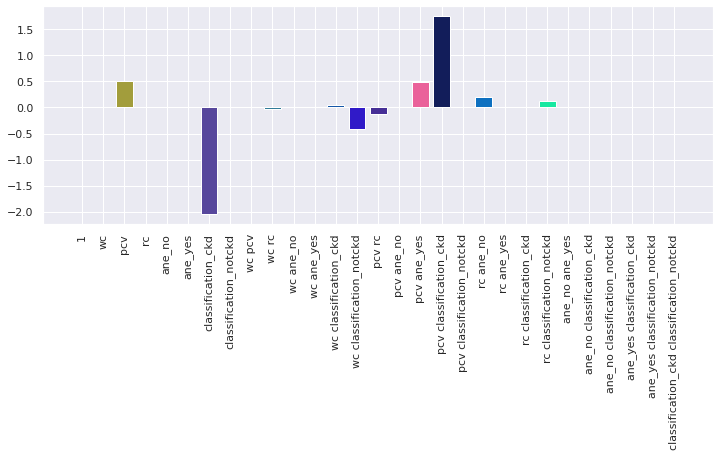

In [37]:
#Generate random colors for chart bar
random_colors = []
for i in range(len(df_coeff.values[0])):
  random_colors.append(fake.hex_color())

#Bar plot the coefficient weights
plt.bar(np.arange(len(df_coeff.values[0])),df_coeff.values[0], color=random_colors)
plt.xticks(np.arange(len(df_coeff.values[0])), list(df_coeff.columns), rotation=90);

In [38]:
#Print the R2 Coefficient of Determination to compare with the less
#complex model
lasso.score(df_train_poly,y_train)

0.8693067293968145

In [39]:
#Mean square error for the train data
mean_squared_error(y_train,lasso.predict(df_train_poly))

1.1410014083893574

In [40]:
#Clean with a function any suspect value in the test set to prevent data leakage
for i in df_test.columns:
  df_test[i].replace(["\t?"],np.nan, inplace=True)

#transform the data with the Pipeline
df_test = pd.DataFrame(preprocessor.transform(df_test))
poly_test = poly.transform(df_test)

In [41]:
#R2 Coefficient of determination score for test set
lasso.score(poly_test, y_test)

0.8233854196615744

In [42]:
#MSE score for test data
mean_squared_error(y_test,lasso.predict(poly_test))

1.3276652028007223

In [43]:
#Difference of MSE from train and test data
np.round(mean_squared_error(y_test,lasso.predict(poly_test))-mean_squared_error(y_train,lasso.predict(df_train_poly)),2)

0.19

In [44]:
#Save the model parameters
pickle.dump(lasso,open("lasso.sav",'wb'))
pickle.dump(preprocessor,open("preprocessor.sav",'wb'))
pickle.dump(poly,open("poly.sav",'wb'))